
## 🔬 เครื่องมือสำหรับตรวจสอบ Data Drift
**สรุปสั้น :**  
- **KS Test (ตัวเลข):** ดูว่า distribution ของตัวเลขสองชุดต่างกันหรือไม่ → ใช้ *p-value* (p < 0.05 = Drift)  
- **Chi-Square (หมวดหมู่):** ดูว่าสัดส่วนของแต่ละหมวดหมู่เปลี่ยนหรือไม่ → ใช้ *p-value* (p < 0.05 = Drift)  
- **JSD (0–1):** วัดระยะห่างระหว่าง distribution (ใกล้ 0 = คล้าย, ใกล้ 1 = ต่าง) → ใช้เกณฑ์แนะนำ **> 0.10** ถือว่ามี drift เชิงปฏิบัติ  
- **PSI:** ใช้บ่อยในสายการเงิน; **< 0.10 = stable**, **0.10–0.25 = moderate**, **≥ 0.25 = significant drift**  

> หมายเหตุ: เกณฑ์ของ JSD/PSI อาจต่างกันตามโดเมนงาน — ที่นี่ใช้เกณฑ์ **เพื่อการสอนเชิงปฏิบัติ**



## 0) Setup (Install/Imports)
รัน cell นี้หากยังไม่มีไลบรารี (โดยเฉพาะ **evidently**, **scipy**). ในสภาพแวดล้อมที่มีอยู่แล้ว สามารถข้าม `pip install` ได้


In [ ]:

# (เลือกได้) ติดตั้งไลบรารี หากยังไม่มี
# !pip install -U pandas numpy scipy evidently

import numpy as np
import pandas as pd
from scipy.stats import ks_2samp, chi2_contingency
from scipy.spatial.distance import jensenshannon

# Evidently (รายงาน Data Drift)
from evidently import *


np.random.seed(42)
pd.set_option("display.max_columns", None)



## 1) สร้างชุดข้อมูลอ้างอิง (Reference) และปัจจุบัน (Current)
เราจะจำลองให้บางคอลัมน์มี drift เพื่อให้นักศึกษาตรวจพบได้จริง:
- **ตัวเลข (numeric):** `age`, `income`, `clicks`
- **หมวดหมู่ (categorical):** `country`, `device`, `channel`


In [20]:

# ขนาดข้อมูล
n_ref = 1200
n_cur = 1000

# --- Reference (train-like) ---
age_ref = np.random.normal(loc=35, scale=9, size=n_ref)                # ปกติ mean 35 sd 9
income_ref = np.random.lognormal(mean=10.5, sigma=0.45, size=n_ref)    # บวกเบี้ยวขวา
clicks_ref = np.random.poisson(lam=5, size=n_ref)                      # นับจำนวน

countries = np.array(["US", "TH", "JP", "IN"])
country_ref = np.random.choice(countries, size=n_ref, p=[0.45, 0.20, 0.20, 0.15])

devices = np.array(["mobile", "desktop", "tablet"])
device_ref = np.random.choice(devices, size=n_ref, p=[0.55, 0.35, 0.10])

channels = np.array(["ads", "organic", "social"])
channel_ref = np.random.choice(channels, size=n_ref, p=[0.40, 0.40, 0.20])

ref = pd.DataFrame({
    "age": age_ref,
    "income": income_ref,
    "clicks": clicks_ref,
    "country": country_ref,
    "device": device_ref,
    "channel": channel_ref
})

# --- Current (production-like) ---
# ทำ drift บางตัว: age เพิ่ม mean, clicks เพิ่มอัตรา, country/device/channel เปลี่ยนสัดส่วน, income เพิ่มความแปรปรวน
age_cur = np.random.normal(loc=39, scale=10, size=n_cur)               # mean ขยับ 35 -> 39
income_cur = np.random.lognormal(mean=10.6, sigma=0.55, size=n_cur)    # sigma เพิ่ม
clicks_cur = np.random.poisson(lam=7, size=n_cur)                      # lam 5 -> 7

country_cur = np.random.choice(countries, size=n_cur, p=[0.35, 0.30, 0.20, 0.15])  # TH เพิ่ม
device_cur = np.random.choice(devices, size=n_cur, p=[0.45, 0.40, 0.15])           # tablet เพิ่ม
channel_cur = np.random.choice(channels, size=n_cur, p=[0.50, 0.30, 0.20])         # ads เพิ่ม

cur = pd.DataFrame({
    "age": age_cur,
    "income": income_cur,
    "clicks": clicks_cur,
    "country": country_cur,
    "device": device_cur,
    "channel": channel_cur
})




In [21]:
ref

,age,income,clicks,country,device,channel
0,39.602939,34530.086066,5,US,desktop,ads
1,37.396854,27523.583806,3,TH,mobile,ads
2,34.163342,55607.688222,7,TH,desktop,organic
3,35.010832,36667.559252,6,US,mobile,ads
4,29.147512,55713.859762,6,JP,mobile,ads
...,...,...,...,...,...,...
1195,23.114226,24753.553455,5,US,mobile,social
1196,44.076596,81886.354431,13,IN,mobile,social
1197,43.295903,14777.899254,4,TH,mobile,social
1198,27.883277,59899.395784,4,TH,tablet,ads


In [22]:
cur

,age,income,clicks,country,device,channel
0,34.054826,28851.455684,5,TH,desktop,organic
1,42.606938,23512.816150,9,JP,mobile,ads
2,29.742286,27129.470830,10,US,tablet,organic
3,38.343613,36288.078211,7,TH,tablet,ads
4,55.566545,43711.467007,11,IN,mobile,social
...,...,...,...,...,...,...
995,47.347401,43215.378283,11,JP,mobile,ads
996,24.878179,22384.291457,5,TH,desktop,organic
997,36.263025,76267.126110,9,IN,mobile,ads
998,27.524517,168487.404137,9,TH,desktop,organic



## 2) ตรวจสอบชนิดข้อมูล (dtypes) และสรุปเบื้องต้น
แยก **ตัวเลข** และ **หมวดหมู่** อัตโนมัติ เพื่อใช้กับเครื่องมือที่เหมาะสม


In [23]:

numeric_cols = ref.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = ref.select_dtypes(exclude=[np.number]).columns.tolist()

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

ref.describe().T


Numeric columns: ['age', 'income', 'clicks']
Categorical columns: ['country', 'device', 'channel']


,count,mean,std,min,25%,50%,75%,max
age,1200.0,35.043509,8.892853,5.568058,28.825055,35.194183,41.232965,61.267347
income,1200.0,40733.817162,19190.320031,6829.429119,26941.198158,36802.944967,50422.595199,143795.788983
clicks,1200.0,4.915000,2.238739,0.000000,3.000000,5.000000,6.000000,14.000000



## 3) KS Test (เฉพาะคอลัมน์ตัวเลข)
ทดสอบความแตกต่างของ distribution ระหว่าง **Reference vs Current**  
**เกณฑ์:** `p-value < 0.05` → ถือว่า Drift


In [24]:

ks_records = []
for c in numeric_cols:
    ref_series = ref[c].dropna()
    cur_series = cur[c].dropna()
    stat, p = ks_2samp(ref_series, cur_series)
    ks_records.append({"column": c, "ks_stat": stat, "p_value": p, "drift_by_ks": p < 0.05})

ks_results = pd.DataFrame(ks_records)
ks_results


,column,ks_stat,p_value,drift_by_ks
0,age,0.205833,1.072019e-20,True
1,income,0.091000,2.220303e-04,True
2,clicks,0.352333,1.319369e-60,True



## 4) Chi-Square Test (เฉพาะคอลัมน์หมวดหมู่)
เปรียบเทียบสัดส่วนของแต่ละหมวดหมู่ระหว่าง **Reference vs Current**  
**เกณฑ์:** `p-value < 0.05` → ถือว่า Drift


In [25]:

chi_records = []
for c in categorical_cols:
    ref_counts = ref[c].value_counts().sort_index()
    cur_counts = cur[c].value_counts().sort_index()
    # รวม category ทั้งสองฝั่งให้ครบ
    all_cats = sorted(set(ref_counts.index).union(set(cur_counts.index)))
    ref_aligned = ref_counts.reindex(all_cats, fill_value=0).values
    cur_aligned = cur_counts.reindex(all_cats, fill_value=0).values
    contingency = pd.DataFrame({"ref": ref_aligned, "cur": cur_aligned}, index=all_cats).T.values
    chi2, p, dof, expected = chi2_contingency(contingency)
    chi_records.append({"column": c, "chi2": chi2, "p_value": p, "drift_by_chi2": p < 0.05})

chi_results = pd.DataFrame(chi_records)
chi_results


,column,chi2,p_value,drift_by_chi2
0,country,62.666869,1.582315e-13,True
1,device,55.326113,9.684725e-13,True
2,channel,38.931531,3.516621e-09,True



## 5) Jensen–Shannon Divergence (JSD) สำหรับตัวเลข
วัดความต่างของ distribution เป็นค่า 0–1 (ยิ่งสูงยิ่งต่าง)  
**เกณฑ์เพื่อการสอน:** `JSD > 0.10` → มี Drift (นักศึกษาสามารถทดลองปรับเกณฑ์เองได้)


In [26]:

jsd_records = []
bins = 20
eps = 1e-12

for c in numeric_cols:
    ref_vals = ref[c].dropna().values
    cur_vals = cur[c].dropna().values
    
    # ใช้ขอบ bin ตาม reference เพื่อความเที่ยงตรงของ PSI/JSD
    ref_hist, bin_edges = np.histogram(ref_vals, bins=bins, density=True)
    cur_hist, _ = np.histogram(cur_vals, bins=bin_edges, density=True)

    # ป้องกัน log(0)
    ref_hist = np.maximum(ref_hist, eps)
    cur_hist = np.maximum(cur_hist, eps)

    jsd = jensenshannon(ref_hist, cur_hist)  # ค่าระหว่าง 0..1
    jsd_records.append({"column": c, "jsd": jsd, "drift_by_jsd": jsd > 0.10})

jsd_results = pd.DataFrame(jsd_records)
jsd_results


,column,jsd,drift_by_jsd
0,age,0.177788,True
1,income,0.089513,False
2,clicks,0.295042,True



## 6) Population Stability Index (PSI) สำหรับตัวเลข
**ขั้นตอนแบบทีละบรรทัด (ไม่มีฟังก์ชัน):**  
1) ใช้ percentile ของ **Reference** สร้าง bin 10 ส่วน  
2) นับสัดส่วน (`%`) ของ **Reference** และ **Current** ในแต่ละ bin  
3) คำนวณ PSI = Σ (ref% - cur%) * ln(ref% / cur%)  
**เกณฑ์:** `< 0.10 = stable`, `0.10–0.25 = moderate`, `≥ 0.25 = significant drift`


In [27]:

psi_records = []
buckets = 10
eps = 1e-12

for c in numeric_cols:
    ref_vals = ref[c].dropna().values
    cur_vals = cur[c].dropna().values

    # สร้าง bin จาก percentile ของ reference
    percentiles = np.linspace(0, 100, buckets + 1)
    bin_edges = np.percentile(ref_vals, percentiles)

    # ป้องกันขอบซ้ำจากค่าซ้ำ
    bin_edges = np.unique(bin_edges)
    if len(bin_edges) < buckets + 1:
        # ถ้าขอบไม่พอ ให้เติม jitter เล็กน้อย
        bin_edges = np.linspace(ref_vals.min(), ref_vals.max(), buckets + 1)

    ref_hist, _ = np.histogram(ref_vals, bins=bin_edges)
    cur_hist, _ = np.histogram(cur_vals, bins=bin_edges)

    ref_pct = ref_hist / max(ref_hist.sum(), 1)
    cur_pct = cur_hist / max(cur_hist.sum(), 1)

    ref_pct = np.maximum(ref_pct, eps)
    cur_pct = np.maximum(cur_pct, eps)

    psi = np.sum((ref_pct - cur_pct) * np.log(ref_pct / cur_pct))
    psi_level = ("stable" if psi < 0.10 else ("moderate" if psi < 0.25 else "significant"))
    psi_records.append({"column": c, "psi": psi, "psi_level": psi_level, "drift_by_psi": psi >= 0.25})

psi_results = pd.DataFrame(psi_records)
psi_results


,column,psi,psi_level,drift_by_psi
0,age,0.225837,moderate,False
1,income,0.049198,stable,False
2,clicks,0.732132,significant,True



## 7) สรุปผลรวม: คอลัมน์ไหน Drift? (พร้อมเหตุผลจากแต่ละวิธี)
- สำหรับ **ตัวเลข**: รวมเกณฑ์จาก **KS (p<0.05)**, **JSD (>0.10)**, **PSI (≥0.25)**  
- สำหรับ **หมวดหมู่**: ใช้ **Chi-Square (p<0.05)**  
> หากคอลัมน์ใดเข้าเกณฑ์อย่างน้อยหนึ่งวิธีที่เหมาะกับชนิดข้อมูลนั้น → เราจะจัดว่า **เกิด Drift**


In [28]:

summary_rows = []

# รวม numeric
for c in numeric_cols:
    ks_row = ks_results.loc[ks_results["column"] == c].iloc[0]
    jsd_row = jsd_results.loc[jsd_results["column"] == c].iloc[0]
    psi_row = psi_results.loc[psi_results["column"] == c].iloc[0]
    drift_flags = [ks_row["drift_by_ks"], jsd_row["drift_by_jsd"], psi_row["drift_by_psi"]]
    any_drift = bool(np.any(drift_flags))
    reasons = []
    if ks_row["drift_by_ks"]:
        reasons.append(f"KS p={ks_row['p_value']:.3g} (<0.05)")
    else:
        reasons.append(f"KS p={ks_row['p_value']:.3g}")
    if jsd_row["drift_by_jsd"]:
        reasons.append(f"JSD={jsd_row['jsd']:.3f} (>0.10)")
    else:
        reasons.append(f"JSD={jsd_row['jsd']:.3f}")
    if psi_row["drift_by_psi"]:
        reasons.append(f"PSI={psi_row['psi']:.3f} (≥0.25)")
    else:
        reasons.append(f"PSI={psi_row['psi']:.3f}")
    summary_rows.append({"column": c, "type": "numeric", "is_drift": any_drift, "reasons": "; ".join(reasons)})

# รวม categorical
for c in categorical_cols:
    chi_row = chi_results.loc[chi_results["column"] == c].iloc[0]
    any_drift = bool(chi_row["drift_by_chi2"])
    reasons = f"Chi2 p={chi_row['p_value']:.3g}" + (" (<0.05)" if any_drift else "")
    summary_rows.append({"column": c, "type": "categorical", "is_drift": any_drift, "reasons": reasons})

drift_summary = pd.DataFrame(summary_rows).sort_values(["type", "column"]).reset_index(drop=True)
drift_summary


,column,type,is_drift,reasons
0,channel,categorical,True,Chi2 p=3.52e-09 (<0.05)
1,country,categorical,True,Chi2 p=1.58e-13 (<0.05)
2,device,categorical,True,Chi2 p=9.68e-13 (<0.05)
3,age,numeric,True,KS p=1.07e-20 (<0.05); JSD=0.178 (>0.10); PSI=...
4,clicks,numeric,True,KS p=1.32e-60 (<0.05); JSD=0.295 (>0.10); PSI=...
5,income,numeric,True,KS p=0.000222 (<0.05); JSD=0.090; PSI=0.049



### ✍️ ตีความผล (Interpretation)
- ดูคอลัมน์ที่ `is_drift = True` ว่าเป็น **คอลัมน์ที่เกิด Data Drift**  
- ใช้คอลัมน์ `reasons` เพื่ออธิบาย **เหตุผล** ที่ผ่านเกณฑ์  
- ตัวอย่าง: หาก `age` มี **KS p < 0.05**, **JSD > 0.10**, **PSI ≥ 0.25** → สรุปว่า distribution ของอายุเปลี่ยนจริง (เช่น mean ขยับ/กระจายกว้างขึ้น)



## 9) สร้างรายงานด้วย Evidently AI
เราจะใช้ **DataDriftPreset** และ **DataQualityPreset** เพื่อสร้างรายงาน HTML ที่ดูง่าย  
- `report.show()` แสดงผลใน Jupyter  
- `report.save_html("evidently_drift_report.html")` เซฟไฟล์เพื่อนำไปแชร์/อัปขึ้น GitHub ได้


In [ ]:
import evidently
print(evidently.__version__)
# ถ้าต่ำกว่า 0.7: pip install -U evidently


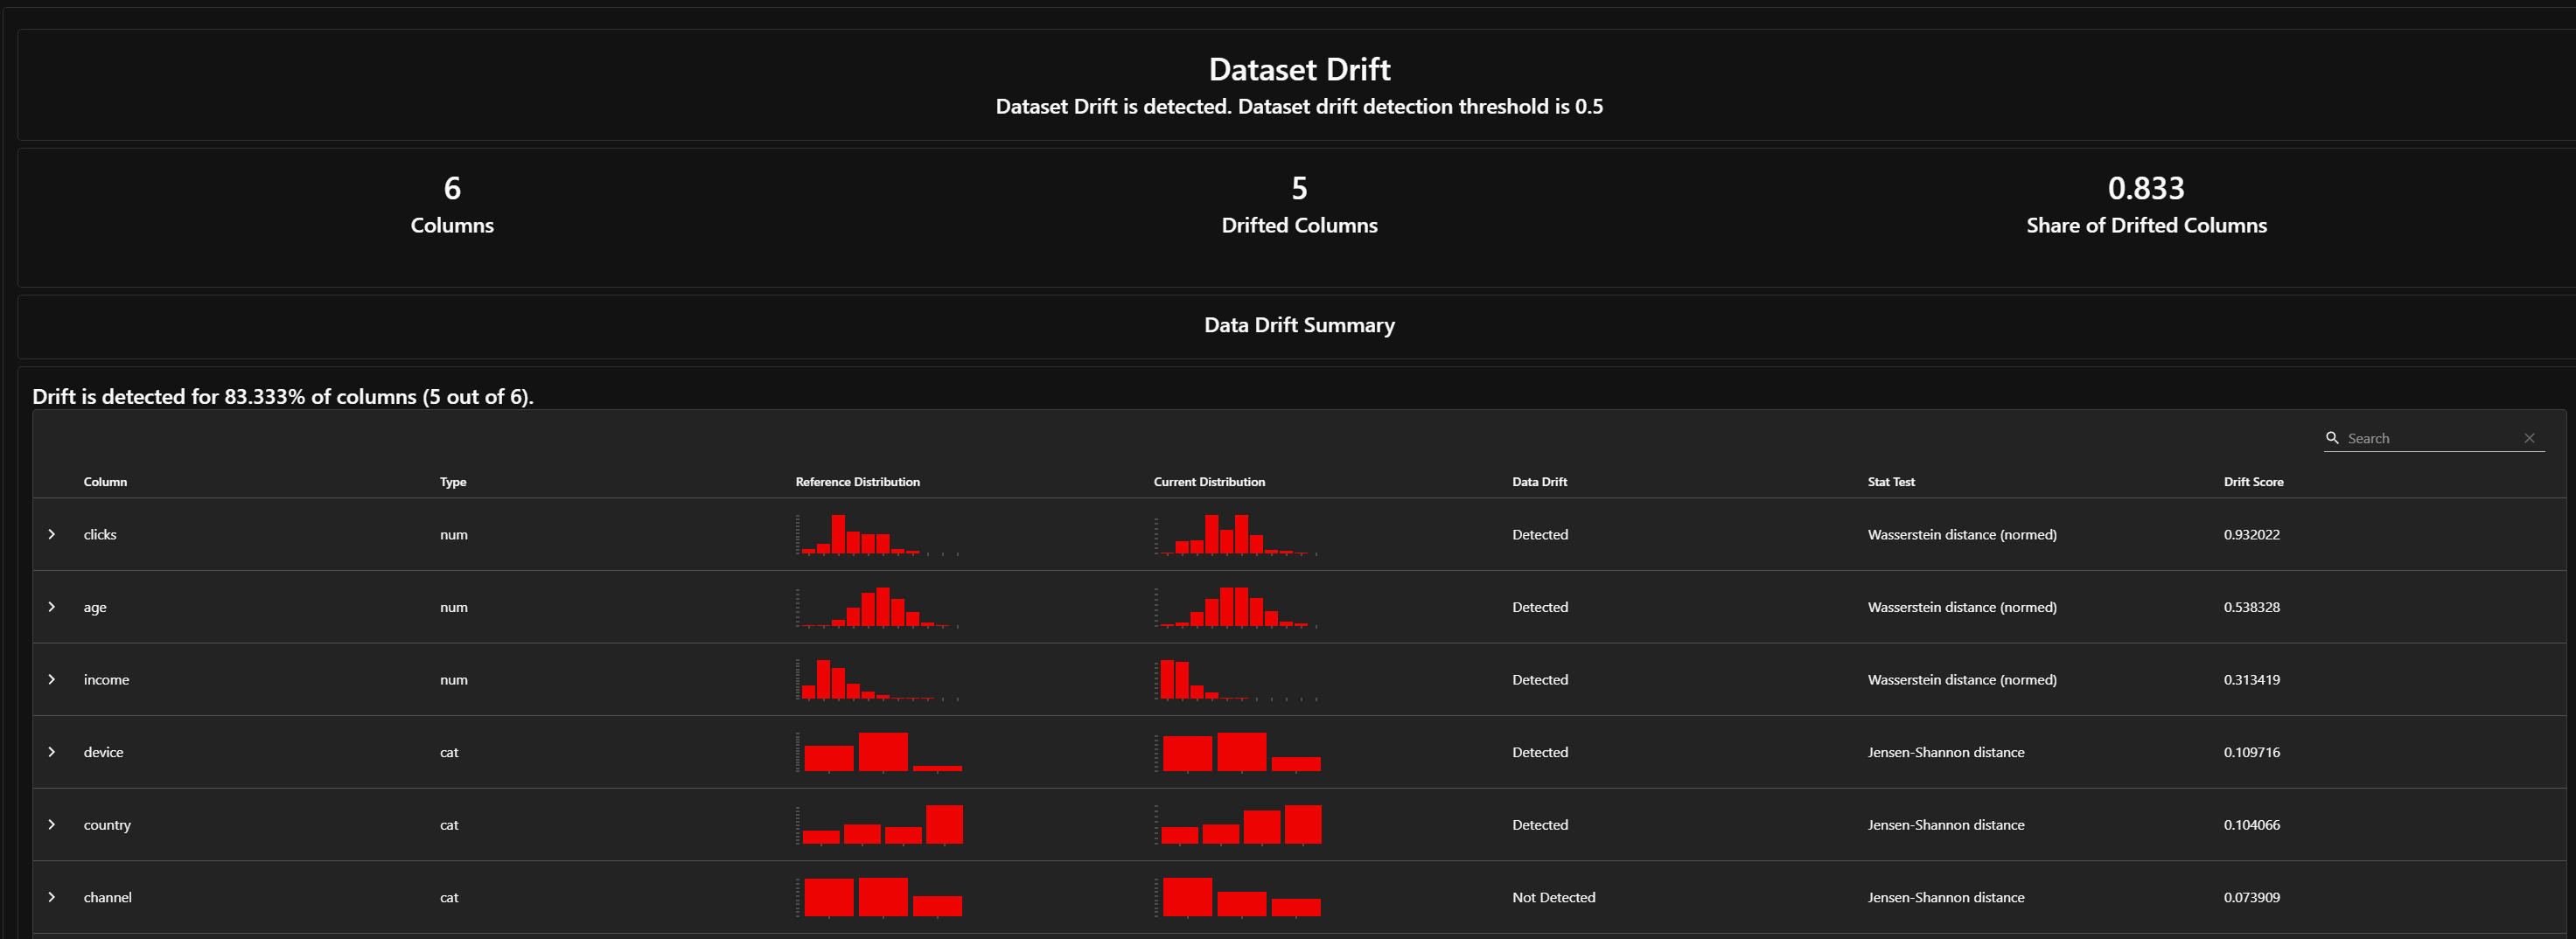

In [ ]:
from evidently import Report
from evidently.presets import DataDriftPreset, DataSummaryPreset


report = Report([
    DataDriftPreset(),
    DataSummaryPreset(),        # แทน DataQualityPreset เดิม
])

eval_result = report.run(current_data=cur, reference_data=ref)


# บันทึกเป็น HTML
eval_result.save_html("evidently_drift_report.html")
print("Saved: evidently_drift_report.html")

eval_result  # หรือ eval_result.show()
